## Import necessary packages

In [1]:
# read data
import os
import shutil

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure

import glob
import csv

## Load images (nifti format)

In [ ]:
basepath = '/Users/jihye/Projects/research/Images/slice*.nii.gz'
paths = sorted(glob.glob(basepath))
print('Images found:', len(paths))

## Functions to display image slice and overlay images with mask

In [ ]:
# function to display image slice; input is numpy 2d array
def show_slice(slice):
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")

# slice based on level and window; input is numpy 2d array
def show_slice_window(slice, level, window):
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max) #values less than min become min and greater than max become max
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")
    plt.savefig('L'+str(level)+'W'+str(window))

# plot the image with mask overlayed on top
def overlay_plot(im, mask):
    plt.figure()
    plt.title('Overlayed plot')
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)
    plt.close()

## Display sample slice with emphasis on tissues and lungs

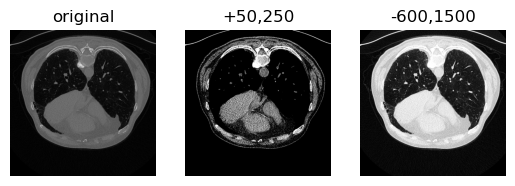

In [20]:
# display sample slice
for c, exam_path in enumerate(paths):
    ct_img = nib.load(exam_path)
    ct_numpy = ct_img.get_fdata() # get array data
    
    if c == 1:
        # show the first slice
        fig,ax = plt.subplots(1,3)
        ax[0].set_title('original')
        ax[0].imshow(ct_numpy.T, cmap="gray", origin="lower")
        ax[0].axis('off')
        
        # show the first slice with emphasis on tissues (HU level 50, window 250)
        ax[1].set_title('+50,250')
        ax[1].imshow(ct_numpy.clip(-75,175).T, cmap="gray", origin="lower")
        ax[1].axis('off')
        
        # show the first slice with emphasis on lungs (HU level -600, window 1500)
        ax[2].set_title('-600,1500')
        ax[2].imshow(ct_numpy.clip(-1350,175).T, cmap="gray", origin="lower")
        ax[2].axis('off')
        plt.show()
        break

## Functions necessary for lung segmentation

In [21]:
# creates directory as specified from path; if exists, it deletes it
def make_dirs(path):
    
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

# clips ct_numpy based on min and max, and returns coordinates of contour found
def intensity_seg(ct_numpy, min, max):
    
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    # find_contours based on value along which to find contours
    # and returns ndarrays w coordinates of contour 
    return measure.find_contours(clipped, 0.95)

# determines whether contour set is closed or not
def set_is_closed(contour):
    
    # if euclidean distance between the first and last contour value is < 1
    if contour_distance(contour) < 1:
        return True
    else:
        return False

# chooses contours that correspond to lungs and body 
# selects closed contour sets with significant volume; the set with greatest volume signifies the body)
# returns contours that correspond to the lung area
def find_lungs(contours):
    
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        # smallest convex set/shape that contains the set of elements
        hull = ConvexHull(contour)
        
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours

# shows contours
def show_contour(image, contours, name=None, save=False):
    
    fig, ax = plt.subplots()
    ax.imshow(image.T, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

    ax.set_xticks([])
    ax.set_yticks([])

    if save:
        plt.savefig(name)
        plt.close(fig)
    else:
        plt.show()

# creates binary mask with image dimensions and converts contours to binary masks
# and merges all them together
def create_mask_from_polygon(image, contours):
    
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y)) # tuple of the x,y coordinates
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return np.fliplr(lung_mask.T)  # transpose it to be aligned with the image dims

# converts masks to 255 to display in nii viewer
# parameters: img_np is binary mask, name is output name, affine is 4x4 np array
def save_nifty(img_np, name, affine):

    img_np[img_np == 1] = 255
    ni_img = nib.Nifti1Image(img_np, affine)
    nib.save(ni_img, name + '.nii.gz')

# get pixdim of ct nib image; returns list of 2 pixel dimension [X, Y]
def find_pix_dim(ct_img):

    # nibabel header contains metadata
    pix_dim = ct_img.header["pixdim"] 
    dim = ct_img.header["dim"]
    max_indx = np.argmax(dim) # indices of max values
    pixdimX = pix_dim[max_indx] # max pixdim value in X
    dim = np.delete(dim, max_indx) # delete all max values
    pix_dim = np.delete(pix_dim, max_indx) # delete all max values
    max_indy = np.argmax(dim) # indice of second max values
    pixdimY = pix_dim[max_indy] # second max pixdim value in Y
    return [pixdimX, pixdimY]

# calculates distance between the first and last point of the set of points in a contour
# contour is np array of x,y points; returns euclidean distance of points
def contour_distance(contour):

    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

# computes area (number of pixels) of binary mask and multiplies pixels with pixel dimensions
# mask is binary lung mask, pixdim is list/tuple with 2 values; returns lung area in mm^2
def compute_area(mask, pixdim):
    
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

## Lung segmentation

slice001 lung area in mm^2: 14218.815117879074
slice002 lung area in mm^2: 34572.27296447754
slice003 lung area in mm^2: 31513.963623046875
slice004 lung area in mm^2: 33388.04453495125
slice005 lung area in mm^2: 32391.739428426652
slice006 lung area in mm^2: 32086.478447489502
slice007 lung area in mm^2: 17640.84075957298
slice008 lung area in mm^2: 26042.239642517397
slice009 lung area in mm^2: 31255.91289323208
slice010 lung area in mm^2: 24475.454391479492
slice011 lung area in mm^2: 18455.89931488037
slice012 lung area in mm^2: 25330.21658706665
slice013 lung area in mm^2: 30042.837661743164
slice014 lung area in mm^2: 30310.75862121582
slice015 lung area in mm^2: 25977.577117919922
slice016 lung area in mm^2: 27387.329864501953
slice017 lung area in mm^2: 15523.084259033203
slice018 lung area in mm^2: 29196.441650390625
slice019 lung area in mm^2: 4298.816299438477
slice020 lung area in mm^2: 12907.887268066406
slice021 lung area in mm^2: 11454.214477539062


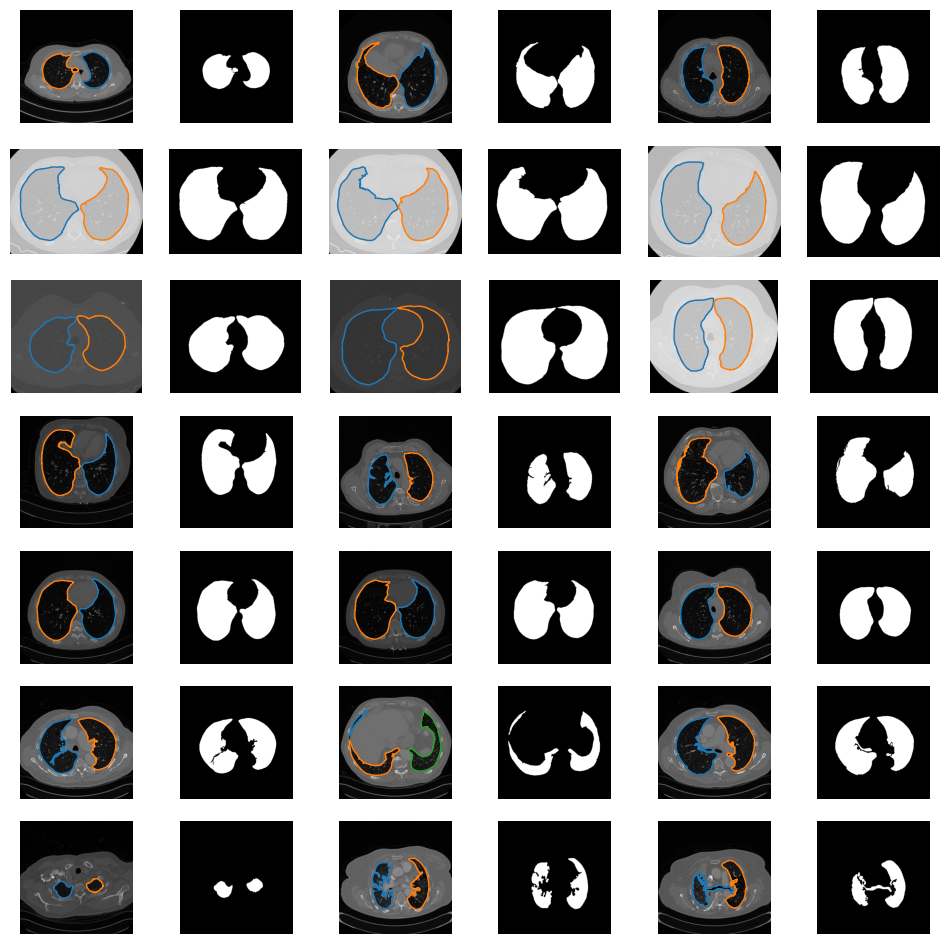

In [23]:
# lung segmentation based on image intensity and medical image processing
outpath = './LUNGS/'
contour_path = './Contours/'
paths = sorted(glob.glob(basepath))
myFile = open('lung_volumes.csv', 'w')
lung_areas = []
make_dirs(outpath)
make_dirs(contour_path)
i = 0

fig,ax = plt.subplots(7,6,figsize=[12,12])

for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0]
    out_mask_name = outpath + img_name + "_mask"
    contour_name = contour_path + img_name + "_contour"

    # 1. find pixel dimensions to calculate the area in mm^2
    ct_img = nib.load(exam_path)
    pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()

    # 2. binarize image using intensity thresholding 
    min_HU = -1000
    max_HU = -300
    
    # 3. contour finding (contour is set of points that describe line or area)
    contours = intensity_seg(ct_numpy, min_HU, max_HU) # expected HU range

    # 4. find lungs of set of possible contours and plot
    lungs = find_lungs(contours)
    ax[int(i/6),int(i%6)].imshow(ct_numpy.T, cmap=plt.cm.gray)
    ax[int(i/6),int(i%6)].axis('off')
    
    # show contours and plot
    for contour in lungs:
        ax[int(i/6),int(i%6)].plot(contour[:,0], contour[:,1], linewidth=1)
    i+=1
    
    # 5. contour to binary mask
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    save_nifty(lung_mask, out_mask_name, ct_img.affine)
    
    # plot
    ax[int(i/6),int(i%6)].imshow(lung_mask.T, cmap="gray", origin="lower")
    ax[int(i/6),int(i%6)].axis('off')
    i+=1

    # compute lung area
    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))
    lung_areas.append([img_name,lung_area]) # int is ok since the units are already mm^2
    print(img_name,'lung area in mm^2:', lung_area)

plt.show()

## Functions necessary for lung vessel segmentation

In [25]:
# lung vessel segmentation
vessels = './Vessels/'
figures = './Figures/'
overlay_path = './Vessel_overlayed/'
paths = sorted(glob.glob(basepath))
myFile = open('vessel_volumes.csv', 'w')
lung_areas_csv = []
ratios = []

make_dirs(vessels)
make_dirs(overlay_path)
make_dirs(figures)

# find euclidean distance
def euclidean_dist(dx, dy):
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

# denoise: remove noise, or presence of artifaces that do not originate from original scene content
def denoise_vessels(lung_contour, vessels):
    # vessels_coords_x and _y are arrays with non zero coordinates
    vessels_coords_x, vessels_coords_y = np.nonzero(vessels)  # get non zero coordinates
    for contour in lung_contour:
        # list of x and y coordinates of each point of contour
        x_points, y_points = contour[:, 0], contour[:, 1]
        for (coord_x, coord_y) in zip(vessels_coords_x, vessels_coords_y):
            for (x, y) in zip(x_points, y_points):
                d = euclidean_dist(x - coord_x, y - coord_y)
                if d <= 0.1: # if vessel mask is too close to lung contour, exclude from vessels
                    vessels[coord_x, coord_y] = 0
    return vessels


def split_array_coords(array, indx=0, indy=1):
    x = [array[i][indx] for i in range(len(array))]
    y = [array[i][indy] for i in range(len(array))]
    return x, y

# create mask of vessels
def create_vessel_mask(lung_mask, ct_numpy, denoise=True):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000 # air
    vessels[vessels >= -500] = 1 # keep values greater than -500  as vessels
    vessels[vessels < -500] = 0
    if denoise:
        return denoise_vessels(lungs_contour, vessels)

    return vessels


Specify denoise=False in create_vessel_mask for quick and noisy results.
Otherwise wait a couple of minutes :)
slice001 Vessel %: 40.861222380152476
slice002 Vessel %: 57.18692605338707
slice003 Vessel %: 31.7018779342723
slice004 Vessel %: 25.93458542038211
slice005 Vessel %: 34.01674670607068
slice006 Vessel %: 30.568881483822164
slice007 Vessel %: 38.02223332838059
slice008 Vessel %: 30.129653859878676
slice009 Vessel %: 17.56965148555567
slice010 Vessel %: 26.25177137458668
slice011 Vessel %: 44.868856633562515
slice012 Vessel %: 25.821474293559938
slice013 Vessel %: 29.629448811209297
slice014 Vessel %: 25.96093359356098
slice015 Vessel %: 29.82271238754846
slice016 Vessel %: 36.68912334223126
slice017 Vessel %: 61.15721013680198
slice018 Vessel %: 33.815580286168526
slice019 Vessel %: 99.64907544877852
slice020 Vessel %: 65.45043314983144
slice021 Vessel %: 70.33759738386073


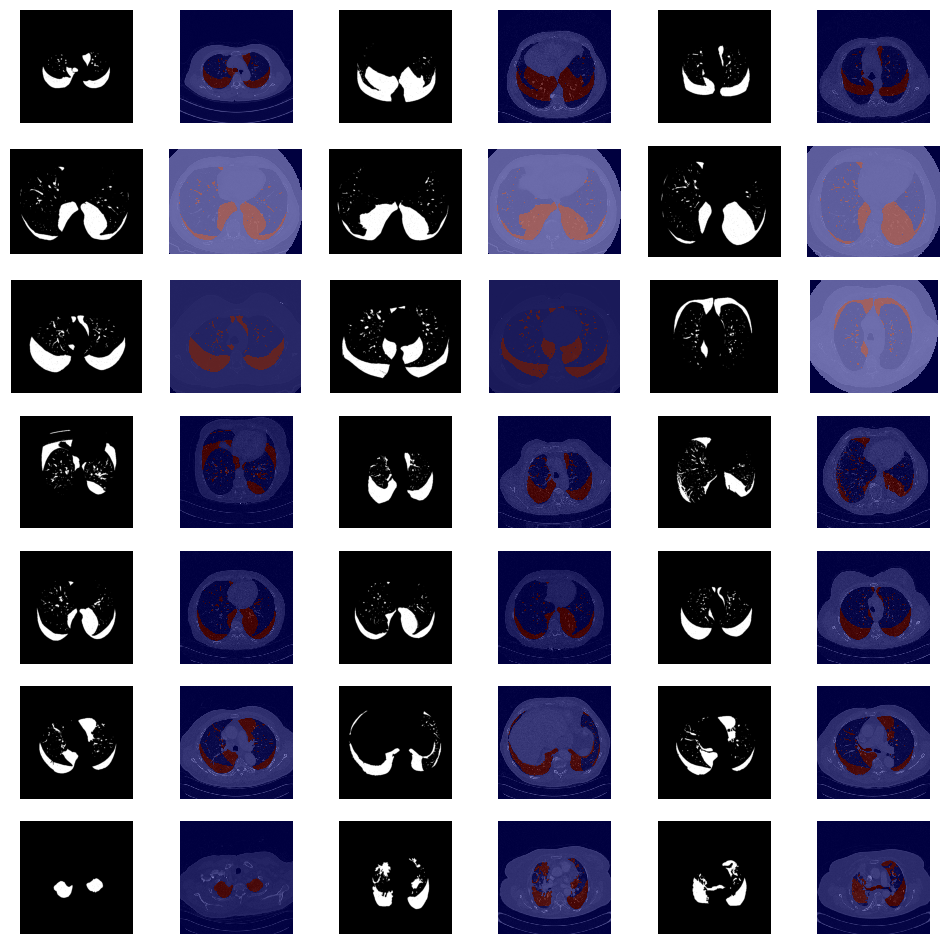

In [26]:
print( "Specify denoise=False in create_vessel_mask for quick and noisy results.")
print( "Otherwise wait a couple of minutes :)")

fig,ax = plt.subplots(7,6,figsize=[12,12])
i=0
    
for c, exam_path in enumerate(paths):
    img_name = exam_path.split("/")[-1].split('.nii')[0]
    vessel_name = vessels + img_name + "_vessel_only_mask"
    overlay_name = overlay_path + img_name + "_vessels"

    # 1. find pixel dimensions to calculate the area in mm^2
    ct_img = nib.load(exam_path)
    pixdim = find_pix_dim(ct_img)
    ct_numpy = ct_img.get_fdata()
    
    # 2. contour finding
    contours = intensity_seg(ct_numpy, -1000, -300)

    # 4. find lungs from set of possible contours and create a mask
    lungs_contour = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs_contour)

    # 5. compute lung area
    lung_area = compute_area(lung_mask, find_pix_dim(ct_img))

    # 6. create a mask of vessels
    vessels_only = create_vessel_mask(lung_mask, ct_numpy, denoise=False)
    ax[int(i/6),int(i%6)].imshow(vessels_only.T, 'gray', origin="lower")
    ax[int(i/6),int(i%6)].axis('off')
    i+=1
    
    # 7. plot image with vessel mask
    ax[int(i/6),int(i%6)].imshow(ct_numpy.T, 'gray', interpolation='none')
    ax[int(i/6),int(i%6)].imshow(np.flipud(vessels_only.T), 'jet', interpolation='none', alpha=0.5)
    ax[int(i/6),int(i%6)].axis('off')
    i+=1
        
    # 7. compute vessel area as well as ratio of vessel area to lung area
    vessel_area = compute_area(vessels_only, find_pix_dim(ct_img))
    ratio = (vessel_area / lung_area) * 100
    print(img_name, 'Vessel %:', ratio)
    lung_areas_csv.append([img_name, lung_area, vessel_area, ratio])
    ratios.append(ratio)
    
plt.show()

## Graphical representation of lung to vessel areas for each slice

Centers 2D: [[13499.9367852   7297.21109309]
 [29569.37624489  9285.01206166]]
Slice labels: [0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0]


Text(0.5, 1.0, 'Clustered ratios')

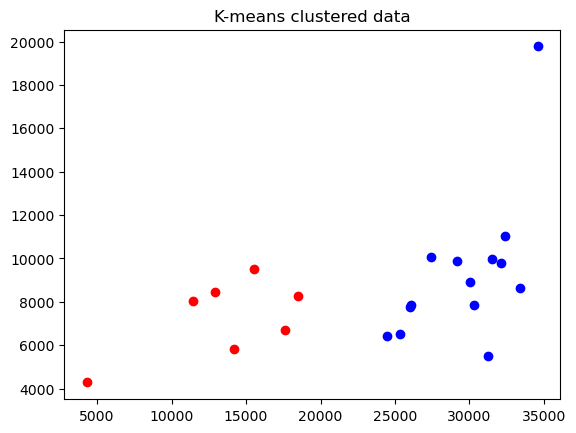

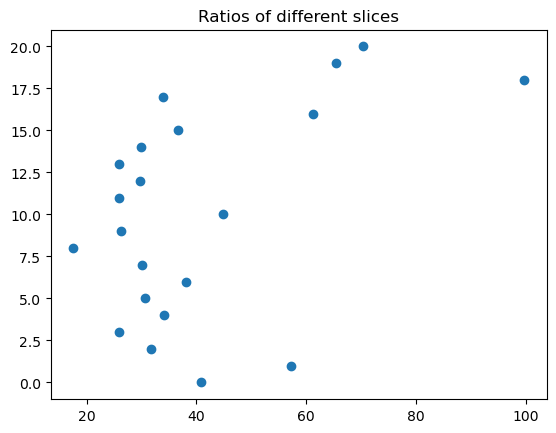

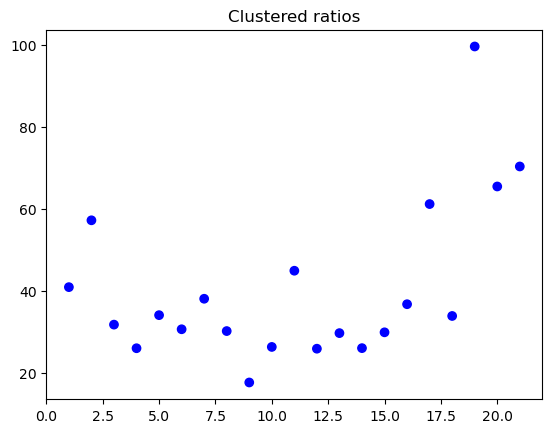

In [6]:
# Data viz here
from sklearn.cluster import KMeans
x, y = split_array_coords(lung_areas_csv, indx=1, indy=2)
data2d = np.stack([np.asarray(x), np.asarray(y)], axis=1) # [[lung_area vessel_area][][]]

kmeans = KMeans(init="random", n_clusters=2, n_init=10)
kmeans.fit(data2d) # compute k-means clustering
print('Centers 2D:', kmeans.cluster_centers_) # center of the clusters (2)
print('Slice labels:', kmeans.labels_) # ndarray with labels of each point (either 0 or 1)

# contains lung and vessel areas for each cluster 
class1 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 0]
class2 = [data2d[i, :] for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == 1]

# plot k means clustered data
plt.figure()
x, y = split_array_coords(class1)
plt.scatter(x, y, c='r')
x, y = split_array_coords(class2)
plt.scatter(x, y, c='b')
plt.title('K-means clustered data')
#plt.savefig('kmeans-clustered')

# plot ratios of different slices
plt.figure()
x, _ = split_array_coords(lung_areas_csv, indx=3, indy=2) # lung to vessel area ratio
plt.scatter(x, np.arange(len(x))) # plot ratios against evenly spaced values
plt.title('Ratios of different slices')
#plt.savefig('./Ratios')

# assign categories
categories = np.zeros(len(x), dtype=int)

for c, i in enumerate(x):
    if i > 6:
        categories[c] = int(1)

colormap = np.array(['r', 'b'])

# plot clustered ratios
plt.figure()
plt.scatter(np.arange(len(x)) + 1, x, c=colormap[categories])
plt.title('Clustered ratios')
#plt.savefig('./clustered_ratios')